In [1]:
library(ggplot2)
library(cowplot)
library(dplyr)
library(tidyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# PCA summary plot for highly transcribed genes

The `nascentwt` pipeline performs DWT on a list of genes, then procceeds to performing PCA on the detail coefficients. The pipeline returns 

1. Detail coeffcients for each gene
2. Approximation coefficients for each gene
3. Summary of the PCA

        i. % variance explained by PC1 and PC2
        ii. PC1 and PC2 values for each sample per gene
        
        
## PCA results

In [2]:
pca_results <- read.table('../data/PCA_results_sym5.tsv',
                     sep = '\t', header=FALSE)

In [3]:
colnames(pca_results) <- c('chr','start','stop','strand',
                           'geneID','pc1','pc2',
                          'pc1_R_gro', 'pc1_L_gro', 'pc1_R_pro', 'pc1_L_pro')
head(pca_results)

,chr,start,stop,strand,geneID,pc1,pc2,pc1_R_gro,pc1_L_gro,pc1_R_pro,pc1_L_pro
,<fct>,<int>,<int>,<fct>,<fct>,<dbl>,<dbl>,<int>,<int>,<int>,<int>
1,chr1,8861001,8878686,-,ENO1,35.13,12.31,0,8,5,5
2,chr1,23691778,23696835,+,RPL11,29.62,16.88,8,0,0,10
3,chr1,28505942,28510892,+,SNHG3,51.02,21.44,0,8,5,5
4,chr1,28508557,28508762,+,SNORA73B,50.64,22.53,0,8,4,6
5,chr1,28505942,28539196,+,RCC1,50.52,19.25,0,8,5,5
6,chr1,28507364,28507571,+,SNORA73A,48.52,28.06,0,8,4,6


## Genes whose PCA separate protocols on PC1 == 0

In [4]:
split1_high <- subset(pca_results, pc1_L_gro == 8 & pc1_R_pro == 10)
split2_high <- subset(pca_results, pc1_R_gro == 8 & pc1_L_pro == 10)
split_high <- rbind(split1_high, split2_high )
dim(split_high)

[1] 87 11

## Genes that can split protocols on a different plane on PC1 and PC2

In [5]:
can_split_high <- pca_results[pca_results$geneID %in% c('ATF4','ATXN2','CALR','CLDND1','DANCR',
                                                        'DDX5','DLGAP1-AS2','EEF2','EIF1','ENO1',
                                                       'EPB41L4A-AS1','EZR','FTH1','FUS',
                                                        'GABPB1-AS1','GPX1','H1F0','H3F3B',
                                                        'HIST1H2AJ','HIST1H2AM','HIST1H3B',
                                                       'HIST1H4B','HIST2H2AB','HIST4H4',
                                                       'HNRNPA1','HSP90AB1','HSPA5','HSPA8',
                                                        'HSPE1','ID2','IER3','IMPDH2','KMT2E-AS1',
                                                       'KRT18','LOC105274304','LRRC75A-AS1',
                                                        'MAT2A','MT1E','MYC','NCBP2-AS2','NOP56',
                                                       'OXLD1','PABPC1','PARTICL','PDP1','PFN1',
                                                       'PPIA','RABGGTB','RACK1','RBM12B','RBM3',
                                                       'RCC1','RPL10','RPL12','RPL13','RPL13A',
                                                       'RPL17','RPL18','RPL18A','RPL19','RPL23A',
                                                       'RPL26','RPL28','RPL29','RPL30','RPL4','RPL7',
                                                       'RPLP1','RPS11','RPS12','RPS13','RPS14',
                                                       'RPS16','RPS20','RPS23','RPS25','RPS26',
                                                       'RPS27','RPS27A','RPS28','RPS2','RPS3A',
                                                       'RPS8','SLC38A2','SNHG12','SNHG16','SNHG1',
                                                       'SNHG25','SNHG3','SNHG7','SNHG8','SNORA24',
                                                       'SNORA57','SNORA65','SNORA73B','SNORD15A',
                                                       'SNORD32A','SNORD35A','SRSF3','SSFA2','TAF1D',
                                                       'TMEM107','TUBA1B','TUBB4B','UBA52',
                                                        'YTHDF3-AS1','ZFAS1','ZFP36L1'),]
dim(can_split_high)

[1] 107  11

## Genes that can not separate the protocols

In [6]:
na <- c('CCND1','CITED2','CKS2','DKK1','EIF5','GADD45B','GAS5','IMP3',
        'MIR3655','RPL17-C18orf32','RPL21','RPL7A','SNHG5','SNORA21',
        'SNORA73A','SNORD95') 
length(na)

[1] 16

# Loading PC1 and PC2 values

In [7]:
pc1 <- read.table("../data/PC1_results_sym5.tsv",sep = '\t', header=FALSE)
pc2 <- read.table("../data/PC2_results_sym5.tsv",sep = '\t', header=FALSE)
sample_ids <- read.table('../data/sample_names.tsv',sep = '\t')
gene_ids <- read.table('../data/gene_names.tsv')


In [8]:
rownames(pc1) <- gene_ids$V1
rownames(pc2) <- gene_ids$V1
colnames(pc1) <- sample_ids$V2
colnames(pc2) <- sample_ids$V2

In [9]:
pc1_gather <- as.data.frame(t(pc1)) %>% gather
pc1_gather$protocol <- rep(sample_ids$V2, nrow(pc1))
pc1_gather$lib_prep <- rep(sample_ids$V3, nrow(pc1))

In [10]:
pc2_gather <- as.data.frame(t(pc2)) %>% gather
pc2_gather$protocol <- rep(sample_ids$V2, nrow(pc2))
pc2_gather$lib_prep <- rep(sample_ids$V3, nrow(pc2))

## Order the genes based on PC separation

In [11]:
pc1_gather1 <- pc1_gather[pc1_gather$key %in% split1_high$geneID,]
pc1_gather2 <- pc1_gather[pc1_gather$key %in% split2_high$geneID,]
pc1_gatherNA <- pc1_gather[pc1_gather$key %in% na,]

In [12]:
split1_high2 <- subset(can_split_high, pc1_L_gro >= 7) 
split2_high2 <- subset(can_split_high, pc1_L_gro < 7 )
split_high2 <- rbind(split1_high2, split2_high2 )

In [13]:
pc1_gather3 <- pc1_gather[pc1_gather$key %in% split1_high2$geneID,]
pc1_gather4 <- pc1_gather[pc1_gather$key %in% split2_high2$geneID,]

In [14]:
pc1_gather1$value <- pc1_gather1$value*-1
pc1_gather3$value <- pc1_gather3$value*-1

In [15]:
pc1_gather_new <- rbind(pc1_gather1,pc1_gather2,
                        pc1_gather3,pc1_gather4,
                        pc1_gatherNA)
pc1_gather_new$key <- factor(pc1_gather_new$key,levels=rev(unique(pc1_gather_new$key)))

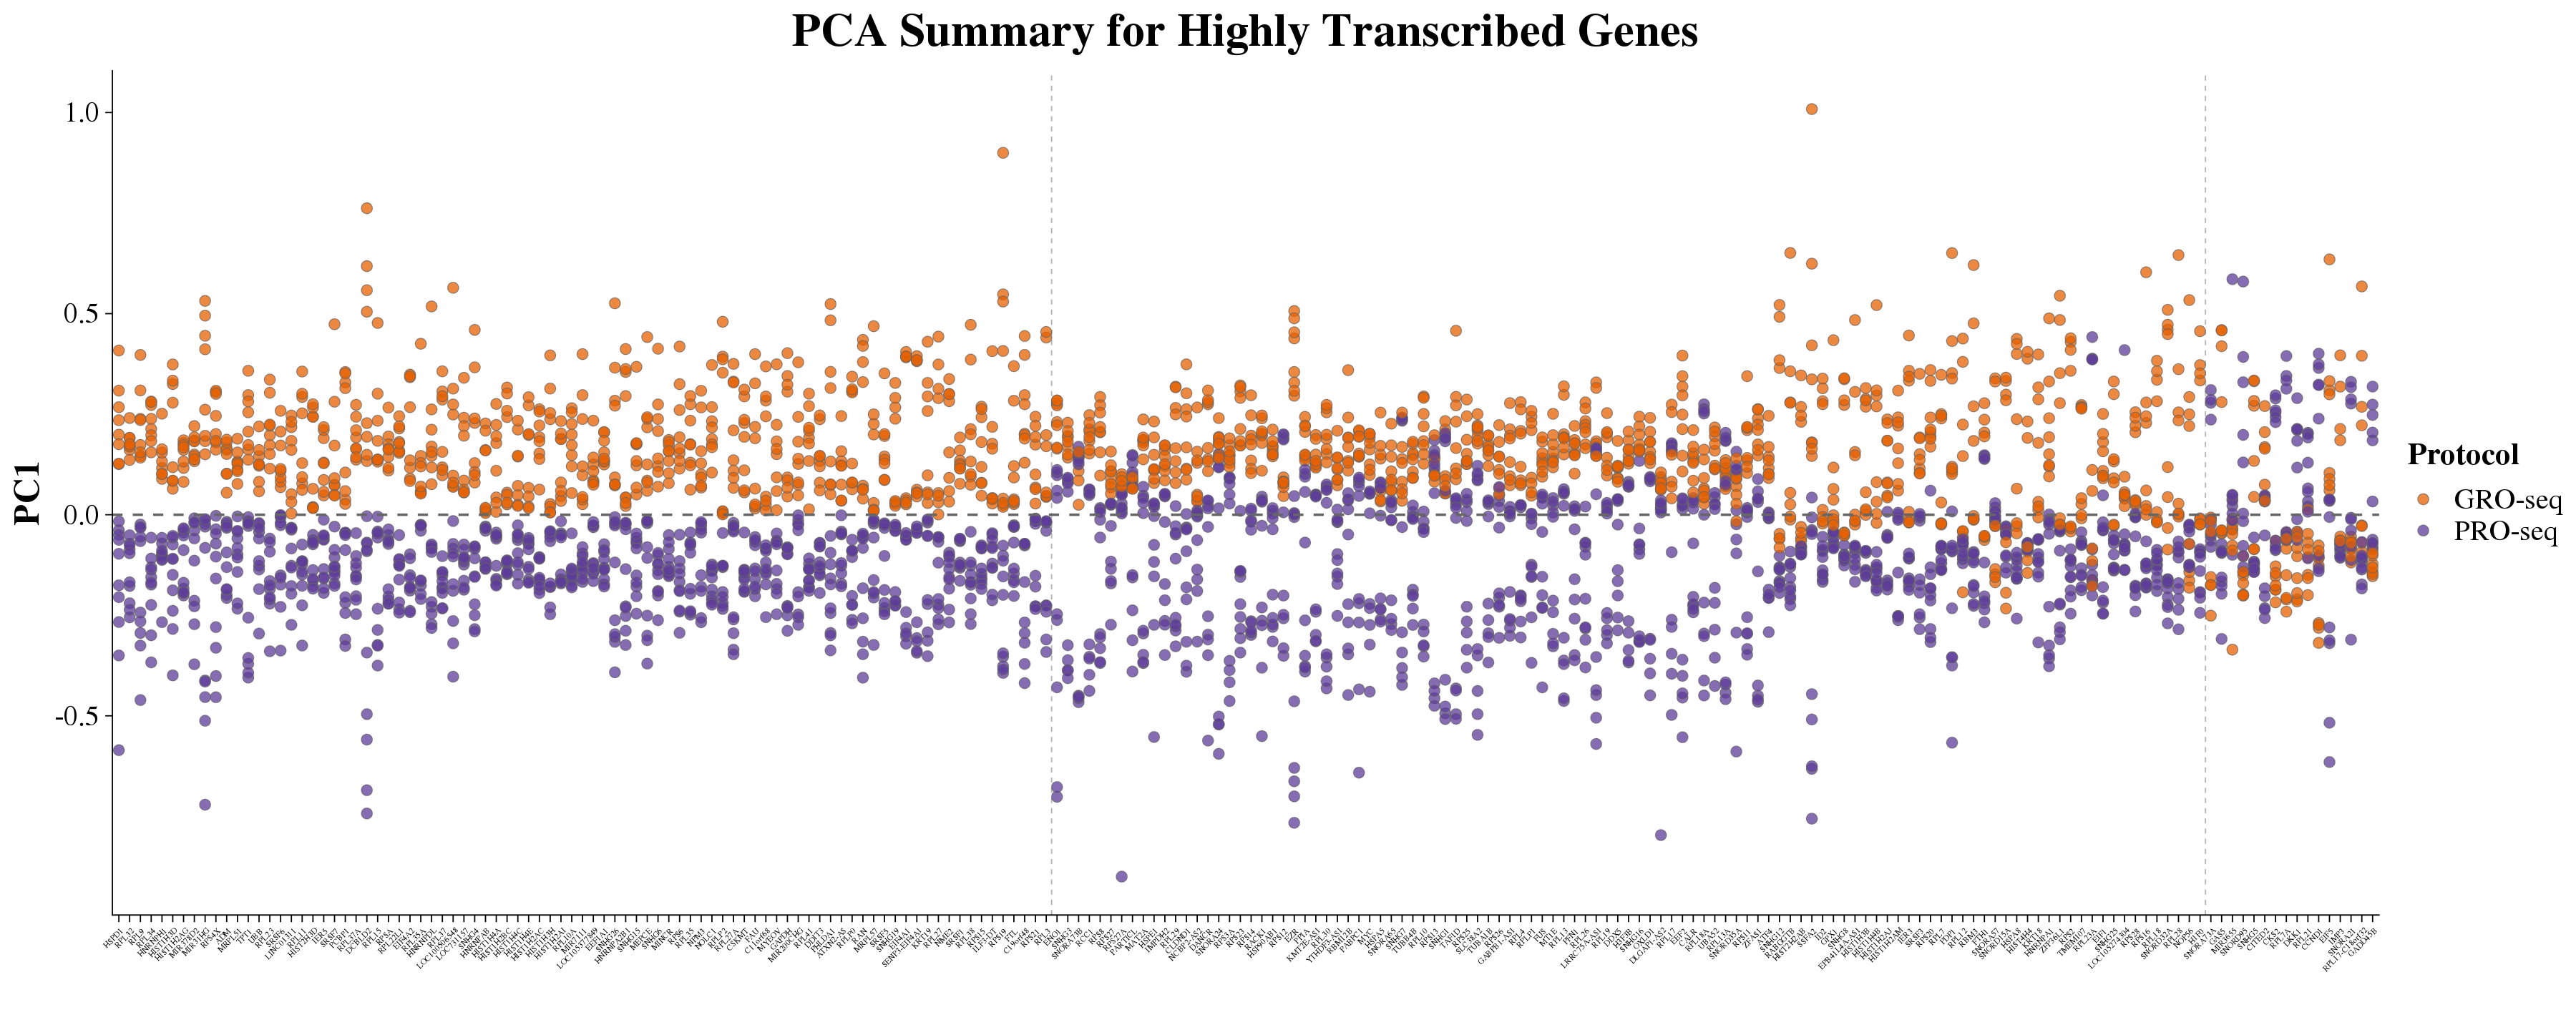

In [16]:
options(repr.plot.width=30, repr.plot.height=12)
genes_pc1_plot <- ggplot(pc1_gather_new, aes(y=value, x=reorder(key, desc(key)), fill=protocol)) + 
            ggtitle("PCA Summary for Highly Transcribed Genes") +
            ylab('PC1') + 
            xlab(' ') + 
            geom_point(size=4, shape=21,color="gray40", alpha=0.75) + 
            scale_fill_manual(name='Protocol',
                              values = c('#e66101','#5e3c99'),
                             labels = c("GRO-seq", "PRO-seq")) +
            geom_hline(yintercept=0, linetype="dashed", 
                            color = "gray40", size=1) +
            geom_vline(xintercept = 87.5, col='gray40', lwd=0.5, alpha=0.5, linetype="dashed") +
            geom_vline(xintercept = 194.5, col='gray40',lwd=0.5, alpha=0.5, linetype="dashed") +
            theme_cowplot(24) +
            theme(plot.title = element_text(hjust = 0.5)) +
            theme(plot.title = element_text(hjust = 0.5, family="Times"),
                  title = element_text(size = 34, family="Times", face = "bold"), 
                  axis.title = element_text(size = 30, family="Times", face = "bold"), 
                  axis.text.x = element_text(size = 7, family="Times",angle = 45, hjust = 0.95),
                  axis.text.y = element_text(size = 24, family="Times"),
                 legend.title = element_text(size = 26, family="Times"),
                 legend.text = element_text(size = 24,family="Times")) 

genes_pc1_plot

In [17]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] tidyr_1.1.2   dplyr_1.0.2   cowplot_1.1.1 ggplot2_3.3.3

loaded via a namespace (and not attached):
 [1] magrittr_2.0.1   tidyselect_1.1.0 munsell_0.5.0    uuid_0.1-4      
 [5] colorspace_2.0-0 R6_2.5.0         rlang_0.4.10     tools_3.6.0     
 [9] grid_3.6.0       gtable_0.3.0     withr_2.3.0      htmltools_0.5.1 
[13] ellipsi